# Section 4.5 — Model selection for causal inference

This notebook contains the code examples from [Section 4.5 Model selection for causal inference]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Figures setup
import matplotlib.pyplot as plt
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
RCPARAMS.update({'figure.figsize': (7, 4)})   # good for screen
# RCPARAMS.update({'figure.figsize': (3, 2.5)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/lm/modelselection"

from ministats.utils import savefigure

<Figure size 640x480 with 0 Axes>

In [3]:
# simple float __repr__
np.set_printoptions(legacy='1.25')

## Definitions

## Causal graphs

### Simple graphs

![](./attachments/dags/panel_simple_DAGs.png)

### More complicated graphs
![](./attachments/dags/panel_elemental_confounds.png)


### Unobserved confounder

<!-- ![](./attachments/dags/fork_DAG_unobserved_U.png) -->

## The fork pattern

![](./attachments/dags/fork_DAG.png)

### Example 1: simple fork

Consider a dataset where there is zero causal effect between $X$ and $Y$.


In [4]:
from scipy.stats import norm
np.random.seed(41)

n = 200
ws = norm(0,1).rvs(n)
xs = 2*ws + norm(0,1).rvs(n)
ys = 0*xs + 3*ws + norm(0,1).rvs(n)

df1 = pd.DataFrame({"x": xs, "w": ws, "y": ys})

First let's fit a native model `y ~ x` to see what happens.

In [5]:
import statsmodels.formula.api as smf
lm1a = smf.ols("y ~ 1 + x", data=df1).fit()
lm1a.params

Intercept   -0.118596
x            1.268185
dtype: float64

Saved figure to figures/lm/modelselection/simple_fork_y_vs_x.pdf
Saved figure to figures/lm/modelselection/simple_fork_y_vs_x.png


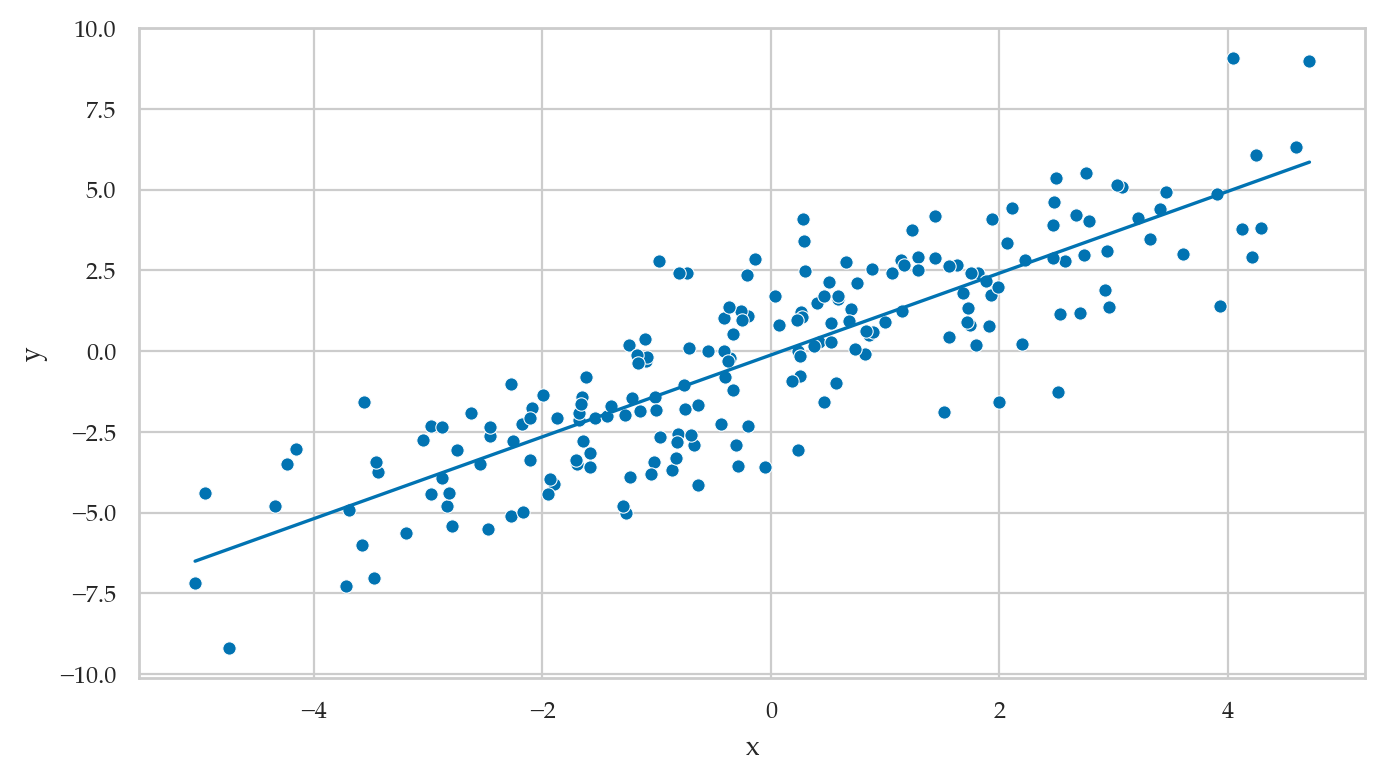

In [6]:
from ministats import plot_reg
plot_reg(lm1a)

filename = os.path.join(DESTDIR, "simple_fork_y_vs_x.pdf")
savefigure(plt.gcf(), filename)

Recall the true strength of the causal association $X \to Y$ is zero,
so the $\widehat{\beta}_{\tt{x}}=1.268$ is a wrong estimate.

Now let's fit another model that controls for the common cause $W$,
and thus removes the confounding.

In [7]:
lm1b = smf.ols("y ~ 1 + x + w", data=df1).fit()
lm1b.params

Intercept   -0.089337
x            0.077516
w            2.859363
dtype: float64

The model `lm1b` correctly recovers causal association close to zero.

Saved figure to figures/lm/modelselection/simple_fork_y_vs_x_given_w.pdf
Saved figure to figures/lm/modelselection/simple_fork_y_vs_x_given_w.png


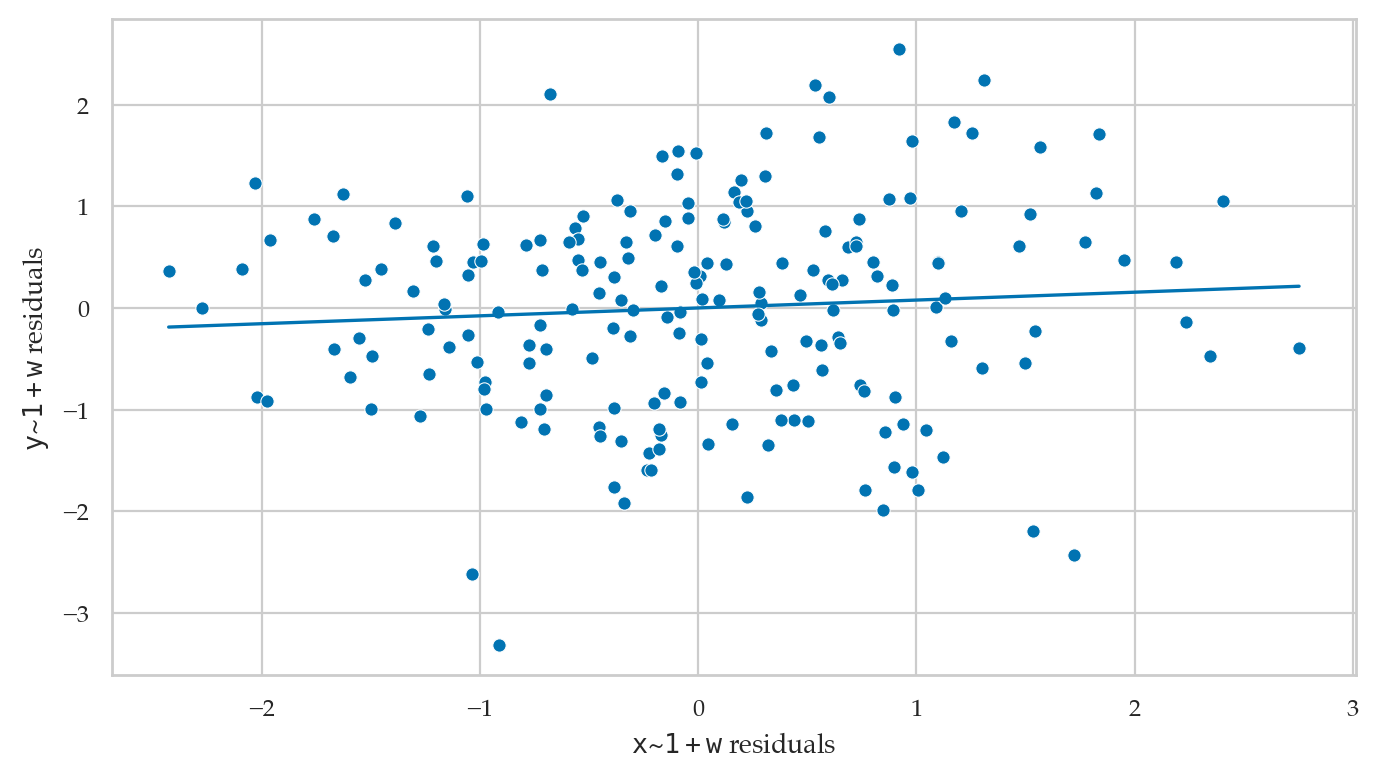

In [8]:
from ministats import plot_partreg
plot_partreg(lm1b, pred="x")

filename = os.path.join(DESTDIR, "simple_fork_y_vs_x_given_w.pdf")
savefigure(plt.gcf(), filename)

### Example 2: student's memory capacity

![](./attachments/dags/score_mem_fork_DAG.png)

In [9]:
np.random.seed(43)

n = 100
mems = norm(5,1).rvs(n)
efforts = 20 - 3*mems + norm(0,1).rvs(n) 
scores = 10*mems + 2*efforts + norm(0,1).rvs(n)

df2 = pd.DataFrame({"mem": mems,
                    "effort": efforts,
                    "score": scores})

First let's fit a model that doesn't account for the common cause. 

In [10]:
lm2a = smf.ols("score ~ 1 + effort", data=df2).fit()
lm2a.params

Intercept    64.275333
effort       -0.840428
dtype: float64

We see a negative effect $\widehat{\beta}_{\tt{effort}}=-0.84$,
the true effect is $+2$.

Now we fit a model that includes `mem`, i.e., we control for the common cause confounder.

In [11]:
lm2b = smf.ols("score ~ 1 + effort + mem", data=df2).fit()
lm2b.params

Intercept    2.650981
effort       1.889825
mem          9.568862
dtype: float64

The model `lm2b` correctly recovers causal association $1.89$,
which is close to the true value $2$.

### Benefits of random assignment

TODO explain

![Randomly assigned effort](./attachments/dags/score_mem_fork_randomized_effort_DAG.png)

### Example 2R: random assignment of the effort variable

Suppose students are randomly assigned into a low effort (5h/week)
and high effort (15h/week) groups by flipping a coin.

In [12]:
from scipy.stats import bernoulli
np.random.seed(47)

n = 300
mems = norm(5,1).rvs(n)
coins = bernoulli(p=0.5).rvs(n)
efforts = 5*coins + 15*(1-coins)
scores = 10*mems + 2*efforts + norm(0,1).rvs(n)

df2r = pd.DataFrame({"mem": mems,
                     "effort": efforts,
                     "score": scores})

The effect of the random assignment is to decouple `effort` from `mem`,
thus removing the association,
as we can see if we compare the correlations in the original dataset `df2`
and the randomized dataset `df2r`.

In [13]:
# non-randomized              # with random assignment
df2.corr()["mem"]["effort"],  df2r.corr()["mem"]["effort"]

(-0.9452404905554658, 0.03700564639546951)

Randomization allows us to recover the correct estimate,
even without including the common cause.

In [14]:
lm2r = smf.ols("score ~ 1 + effort", data=df2r).fit()
lm2r.params

Intercept    49.176242
effort        2.077639
dtype: float64

Note we can also including `mem` in the model,
and that doesn't hurt.

In [15]:
lm2rm = smf.ols("score ~ 1 + effort + mem", data=df2r).fit()
lm2rm.params

Intercept    -0.343982
effort        2.002295
mem          10.063906
dtype: float64

## The pipe pattern

![](./attachments/dags/pipe_DAG.png)

### Example 3: simple pipe

In [16]:
np.random.seed(42)

n = 300
xs = norm(0,1).rvs(n)
ms = xs + norm(0,1).rvs(n)
ys = ms + norm(0,1).rvs(n)

df3 = pd.DataFrame({"x": xs, "m": ms, "y": ys})

First we fit the model `y ~ 1 + x` that doesn't include the variable $M$,
which is the correct thing to do.

In [17]:
lm3a = smf.ols("y ~ 1 + x", data=df3).fit()
lm3a.params

Intercept    0.060272
x            0.922122
dtype: float64

Saved figure to figures/lm/modelselection/simple_pipe_y_vs_x.pdf
Saved figure to figures/lm/modelselection/simple_pipe_y_vs_x.png


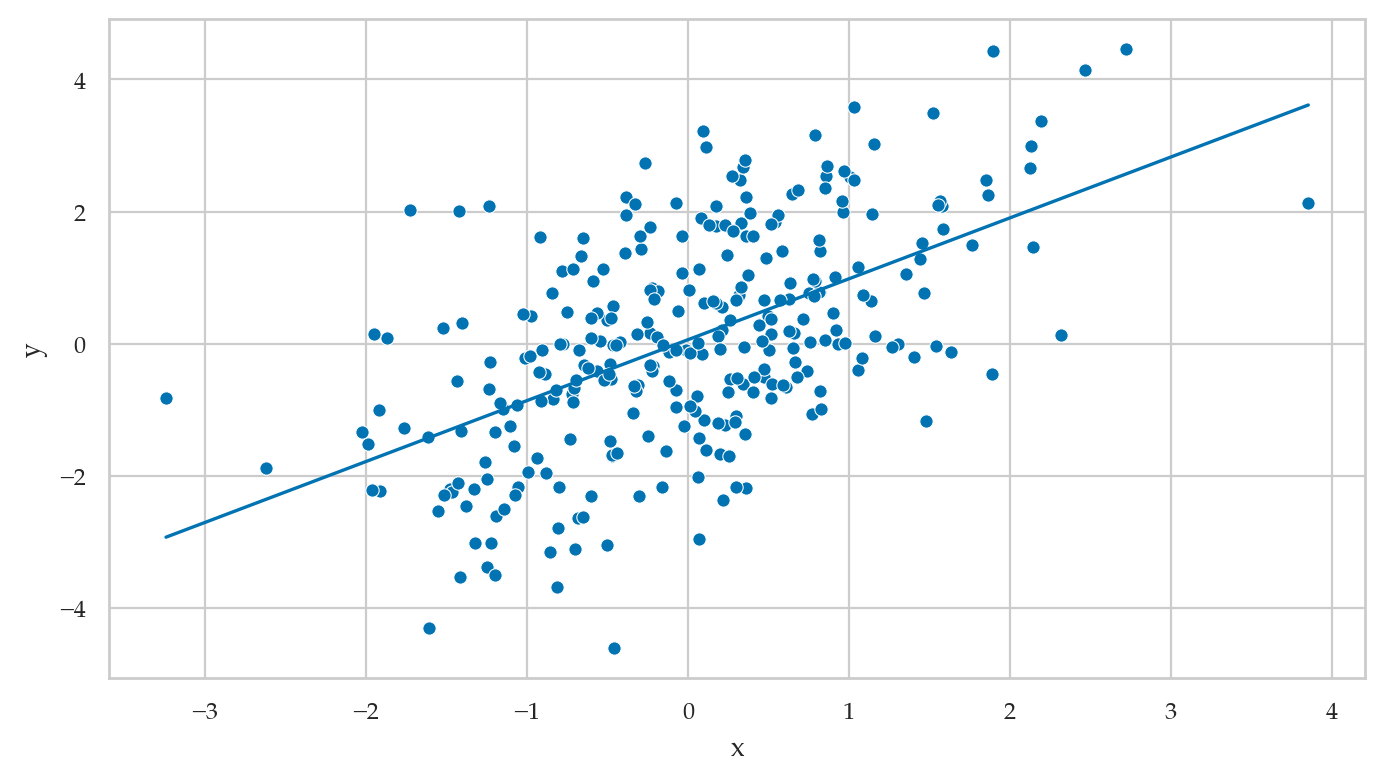

In [18]:
from ministats import plot_reg
plot_reg(lm3a)

ax = plt.gca()
# ax.set_title("Regression plot")
filename = os.path.join(DESTDIR, "simple_pipe_y_vs_x.pdf")
savefigure(plt.gcf(), filename)

However,
if we were choose to include $M$ in the model,
we get a completely different result.

In [19]:
lm3b = smf.ols("y ~ 1 + x + m", data=df3).fit()
lm3b.params

Intercept    0.081242
x           -0.005561
m            0.965910
dtype: float64

Saved figure to figures/lm/modelselection/simple_pipe_y_vs_x_given_m.pdf
Saved figure to figures/lm/modelselection/simple_pipe_y_vs_x_given_m.png


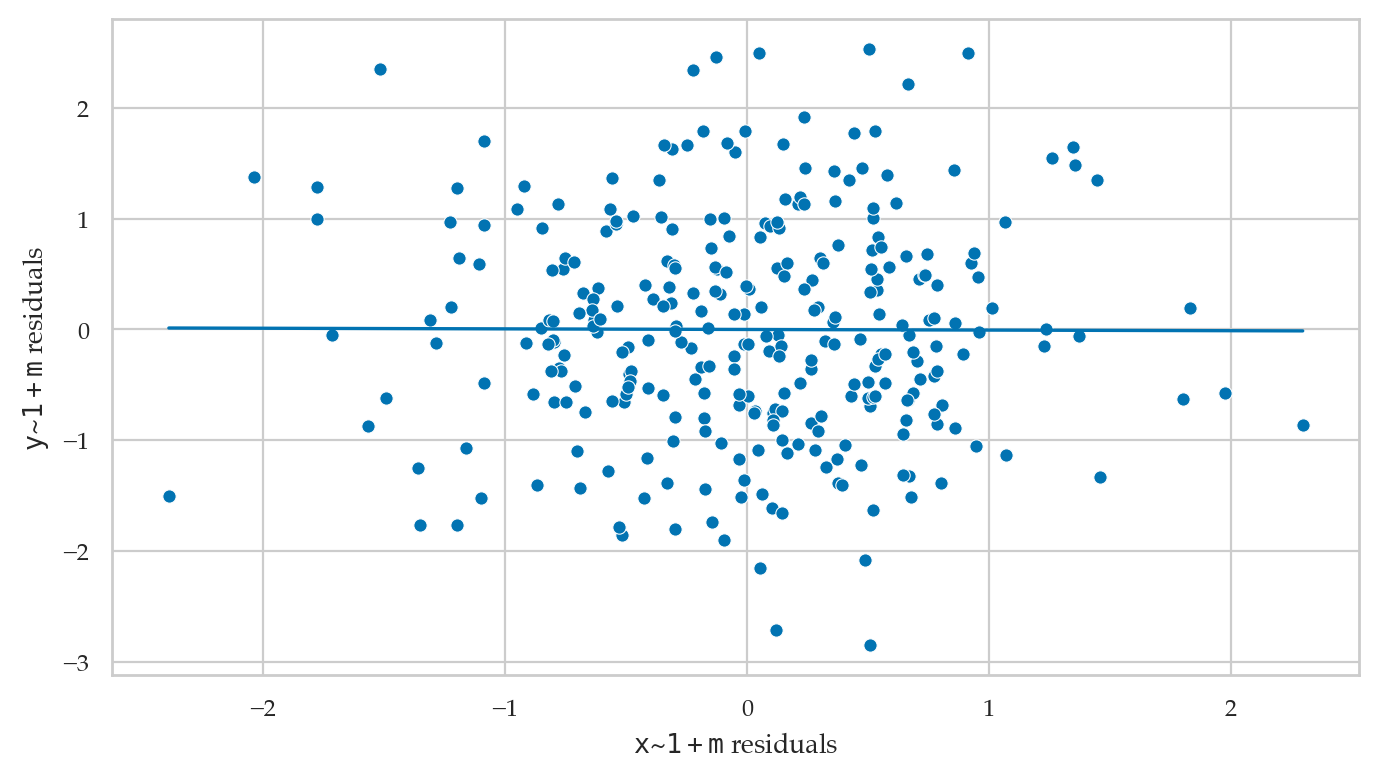

In [20]:
from ministats import plot_partreg
plot_partreg(lm3b, pred="x");

filename = os.path.join(DESTDIR, "simple_pipe_y_vs_x_given_m.pdf")
savefigure(plt.gcf(), filename)

In [21]:
# ALT
# from statsmodels.graphics.api import plot_partregress
# with plt.rc_context({"figure.figsize":(3, 2.5)}):
#     plot_partregress("y", "x",  exog_others=["m"], data=df3, obs_labels=False)
#     ax = plt.gca()
#     ax.set_title("Partial regression plot")
#     ax.set_xlabel("e(x | m)")
#     ax.set_ylabel("e(y | m)")
#     filename = os.path.join(DESTDIR, "simple_pipe_partregress_y_vs_x.pdf")
#     savefigure(plt.gcf(), filename)

In [22]:
# # OLD ALT. using plot_lm_partial not a good plot,
# #      since it still shows the trend
# from ministats import plot_lm_partial
# sns.scatterplot(data=df3, x="x", y="y")
# plot_lm_partial(lm3b, "x")
# filename = os.path.join(DESTDIR, "simple_pipe_y_vs_x_given_m.pdf")
# savefigure(plt.gcf(), filename)

### Example 4: student competency as a mediator

Students `score` as a function of `effort`.
We assume the final scores for the course was mediated through improvements in competency with the material (`comp`).

![](./attachments/dags/score_comp_pipe_DAG.png)

In [23]:
np.random.seed(42)

n = 200
efforts = norm(9,2).rvs(n)
comps = 2*efforts + norm(0,1).rvs(n)
scores = 3*comps + norm(0,1).rvs(n)

df4 = pd.DataFrame({"effort": efforts,
                    "comp": comps,
                    "score": scores})

The causal graph in this situation is an instance of the mediator pattern,
so the correct modelling decision is not to include the `comp` variable,
which allows us to recover the correct parameter.

In [24]:
lm4a = smf.ols("score ~ 1 + effort", data=df4).fit()
lm4a.params

Intercept   -0.538521
effort       6.079663
dtype: float64

However,
if we make the mistake of including the variable `comp` in the model,
we will obtain a zero parameter for the effort,
which is a wrong conclusion.

In [25]:
lm4b = smf.ols("score ~ 1 + effort + comp", data=df4).fit()
lm4b.params

Intercept    0.545934
effort      -0.030261
comp         2.979818
dtype: float64

It even appears that effort has a small negative effect.

## The collider pattern

![](./attachments/dags/collider_DAG.png)

### Example 5: simple collider

In [26]:
np.random.seed(42)

n = 300
xs = norm(0,1).rvs(n)
ys = norm(0,1).rvs(n)
zs = (xs + ys >= 1.7).astype(int)

df5 = pd.DataFrame({"x": xs, "y": ys, "z": zs})

Note `y` is completely independent of `x`.
And if we were to fit the model `y ~ x` we get the correct result.

In [27]:
lm5a = smf.ols("y ~ 1 + x", data=df5).fit()
lm5a.params

Intercept   -0.021710
x           -0.039576
dtype: float64

Saved figure to figures/lm/modelselection/simple_collider_y_vs_x.pdf
Saved figure to figures/lm/modelselection/simple_collider_y_vs_x.png


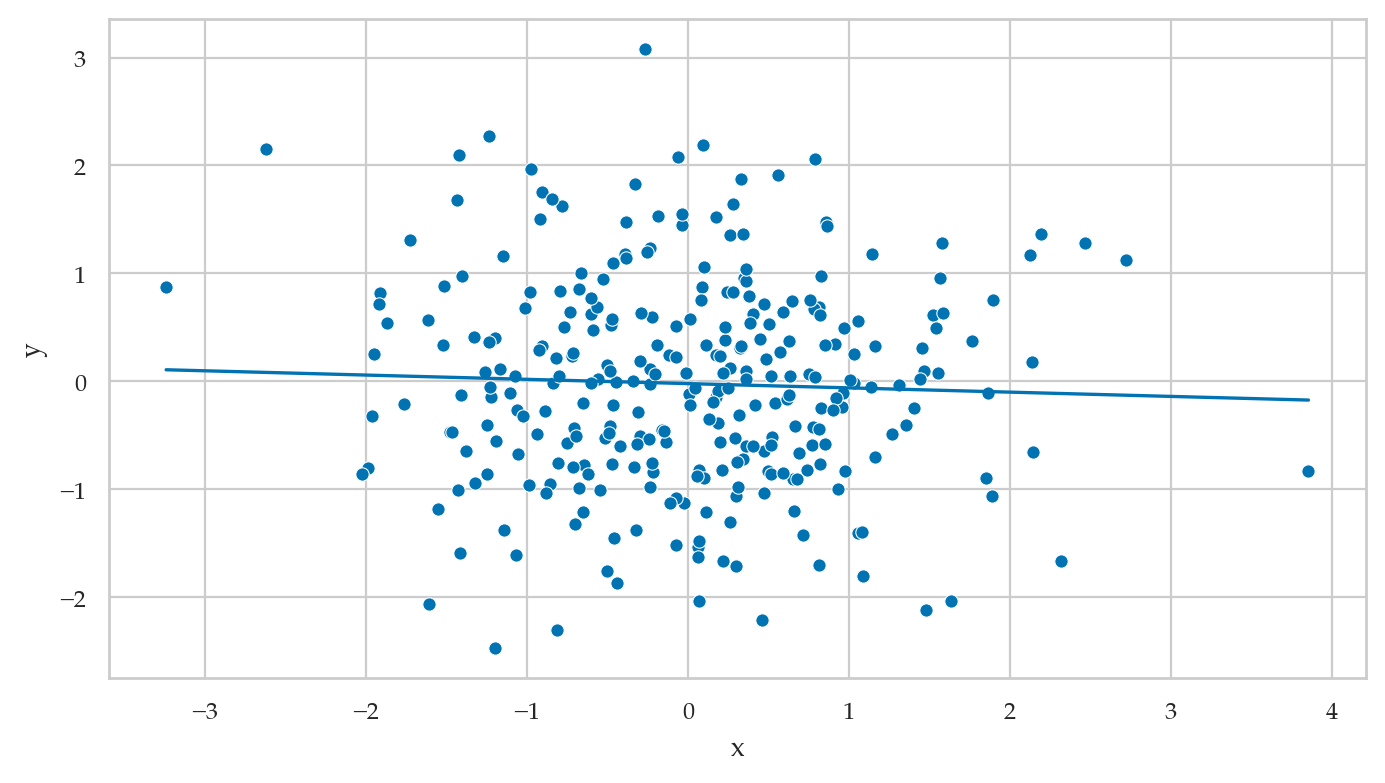

In [28]:
plot_reg(lm5a)

ax = plt.gca()
filename = os.path.join(DESTDIR, "simple_collider_y_vs_x.pdf")
savefigure(plt.gcf(), filename)

Including $Z$ in the model incorrectly shows  $X \to Y$ association.

In [29]:
lm5b = smf.ols("y ~ 1 + x + z", data=df5).fit()
lm5b.params

Intercept   -0.170415
x           -0.244277
z            1.639660
dtype: float64

Saved figure to figures/lm/modelselection/simple_collider_y_vs_x_given_z.pdf
Saved figure to figures/lm/modelselection/simple_collider_y_vs_x_given_z.png


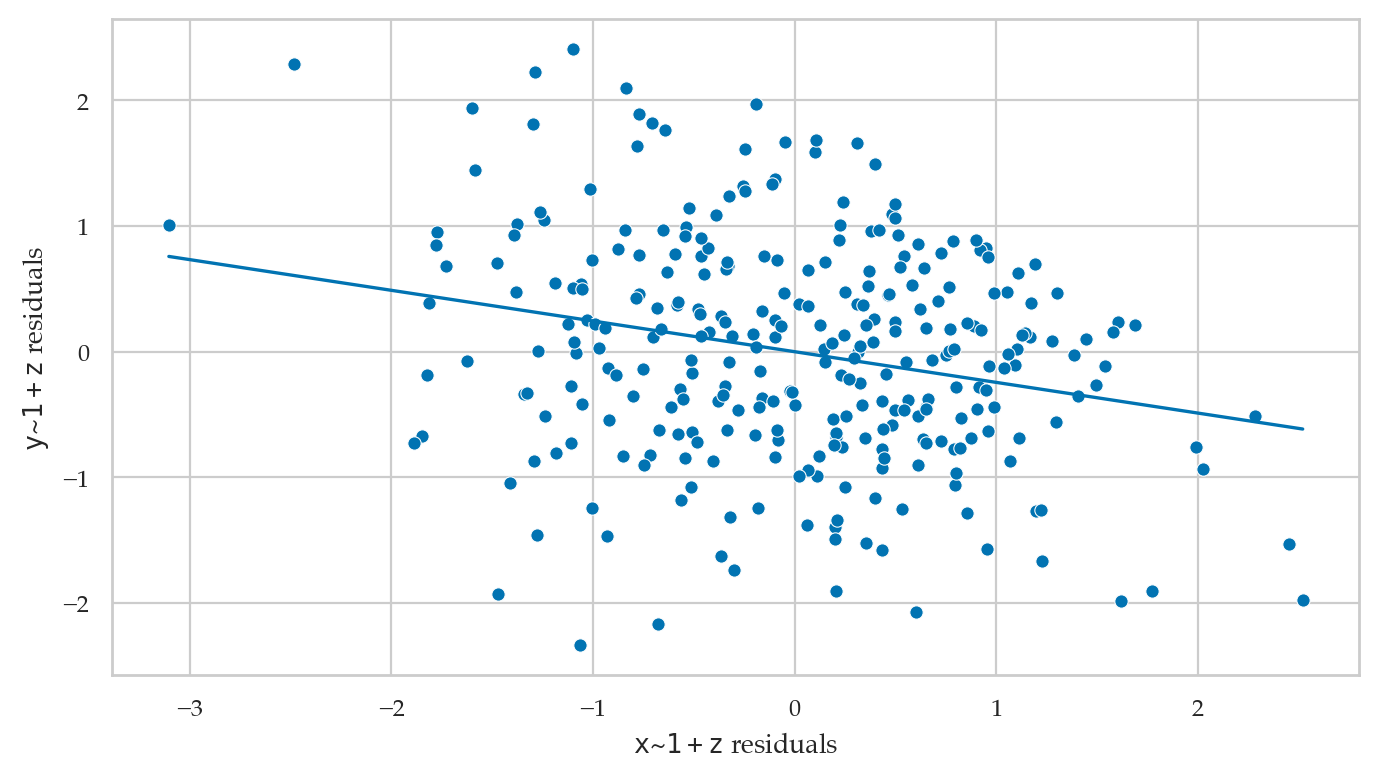

In [30]:
from ministats import plot_partreg
plot_partreg(lm5b, pred="x");

filename = os.path.join(DESTDIR, "simple_collider_y_vs_x_given_z.pdf")
savefigure(plt.gcf(), filename)

### Example 6: student GPA as a collider

![](./attachments/dags/score_gpa_collider_DAG.png)

In [31]:
np.random.seed(46)

n = 300
efforts = norm(9,2).rvs(n)
scores = 5*efforts + norm(10,10).rvs(n)
gpas = 0.1*efforts + 0.02*scores + norm(0.6,0.3).rvs(n)

df6 = pd.DataFrame({"effort": efforts,
                    "score": scores,
                    "gpa": gpas})

When we don't adjust for the collider `gpa`,
we obtain the correct effect of effort on scores.

In [32]:
lm6a = smf.ols("score ~ 1 + effort", data=df6).fit()
lm6a.params

Intercept    12.747478
effort        4.717006
dtype: float64

But with adjustment for `gpa` reduces the effect significantly.

In [33]:
lm6b = smf.ols("score ~ 1 + effort + gpa", data=df6).fit()
lm6b.params

Intercept     1.464950
effort        1.177600
gpa          16.624215
dtype: float64

### Selection bias as a collider

https://en.wikipedia.org/wiki/Berkson's_paradox


### Example 6SB: selection bias

Suppose the study was conducted only on students who obtained an `award`,
which is given to students with GPA 3.4 or greater.

![ ](./attachments/dags/score_award_selection_bias_DAG.png)

In [34]:
df6sb = df6[df6["gpa"]>=3.4]
lm6sb = smf.ols("score ~ 1 + effort", data=df6sb).fit()
lm6sb.params

Intercept    78.588495
effort       -0.126503
dtype: float64

A negative causal association appears,
which is very misleading.

## Explanations

### Backdoor path criterion

#### Revisiting the three patterns

#### Examples of more complicated graphs

##### (a) Pipe and fork

Summary:
- confounder of the mediator $M$ also confounds $X$ and $Y$
- unadjusted estimate is biased
- adjusting for $Z$ blocks backdoor path
- $Z$ is a ***good*** control

In [35]:
from scipy.stats import norm

np.random.seed(42)

n = 1000
ws = norm(0,1).rvs(n)
xs = ws + norm(0,1).rvs(n)
ms = xs + ws + norm(0,1).rvs(n)
ys = ms + norm(0,1).rvs(n)
dfa = pd.DataFrame({"w":ws, "x":xs, "m":ms, "y":ys})

# unadjusted estimate is confounded
lma_unadj = smf.ols("y ~ 1 + x", data=dfa).fit()
print(lma_unadj.params)

# adjusting for W recovers the causal effect
lma_adj = smf.ols("y ~ 1 + x + w", data=dfa).fit()
print(lma_adj.params)

Intercept   -0.034927
x            1.458856
dtype: float64
Intercept   -0.008234
x            0.932850
w            1.072638
dtype: float64


##### (b) M-bias example

Summary:
- although $Z$ is a pre-treament variable, as well as correlated both with $X$ and $Y$,
  it is *not* a confounder
- unadjusted estimate is unbiased
- adjusting for $Z$ *opens* the colliding path $X \leftarrow P \rightarrow Z \leftarrow Q \rightarrow Y$
- $Z$ is a ***bad*** control

In [36]:
# simulate data (linear model)
np.random.seed(47)

n = 1000
ps = norm(0,1).rvs(n)
qs = norm(0,1).rvs(n)
zs = ps + qs + norm(0,1).rvs(n)
xs = ps + norm(0,1).rvs(n)
ys = xs - 4*qs + norm(0,1).rvs(n)
dfb = pd.DataFrame({"x":xs, "p":ps, "q":qs, "z":zs, "y":ys})

# unadjusted estimate is *not* confounded!
lmb_unadj = smf.ols("y ~ 1 + x", data=dfb).fit()
print(lmb_unadj.params)

# adjusting for Z induces bias!
lmb_adj = smf.ols("y ~ 1 + x + z", data=dfb).fit()
print(lmb_adj.params)

Intercept   -0.205050
x            0.964068
dtype: float64
Intercept   -0.171269
x            1.720329
z           -1.592446
dtype: float64


##### (c) Indirect confounder


In [37]:
np.random.seed(47)

n = 1000
ws = norm(0,1).rvs(n)
vs = ws + norm(0,1).rvs(n)
xs = ws + norm(0,1).rvs(n)
ys = xs - vs + norm(0,1).rvs(n)
dfc = pd.DataFrame({"x":xs, "v":vs, "w":ws, "y":ys})

# unadjusted estimate is confounded
lmc_unadj = smf.ols("y ~ 1 + x", data=dfc).fit()
print(lmc_unadj.params)

# adjusting for W (or V) recovers the causal effect
lmc_adj = smf.ols("y ~ 1 + x + w", data=dfc).fit()
print(lmc_adj.params)

Intercept   -0.134730
x            0.487507
dtype: float64
Intercept   -0.083954
x            1.014572
w           -1.068072
dtype: float64


### Three different goals when building models

### The Table 2 fallacy

## Case study: smoking and lung function in teens



In [38]:
smokefev = pd.read_csv("../datasets/smokefev.csv")
print(smokefev.tail(3))

     age    fev  height sex smoke
651   18  2.853    60.0   F    NS
652   16  2.795    63.0   F    SM
653   15  3.211    66.5   F    NS


In [39]:
print(smokefev.describe().round(3))

           age      fev   height
count  654.000  654.000  654.000
mean     9.931    2.637   61.144
std      2.954    0.867    5.704
min      3.000    0.791   46.000
25%      8.000    1.981   57.000
50%     10.000    2.548   61.500
75%     12.000    3.118   65.500
max     19.000    5.793   74.000


In [40]:
smokefev.groupby("smoke")["fev"].mean()

smoke
NS    2.566143
SM    3.276862
Name: fev, dtype: float64

In [41]:
meanSM = smokefev[smokefev["smoke"]=="SM"]["fev"].mean()
meanNS = smokefev[smokefev["smoke"]=="NS"]["fev"].mean()
meanSM - meanNS

0.7107189238605196

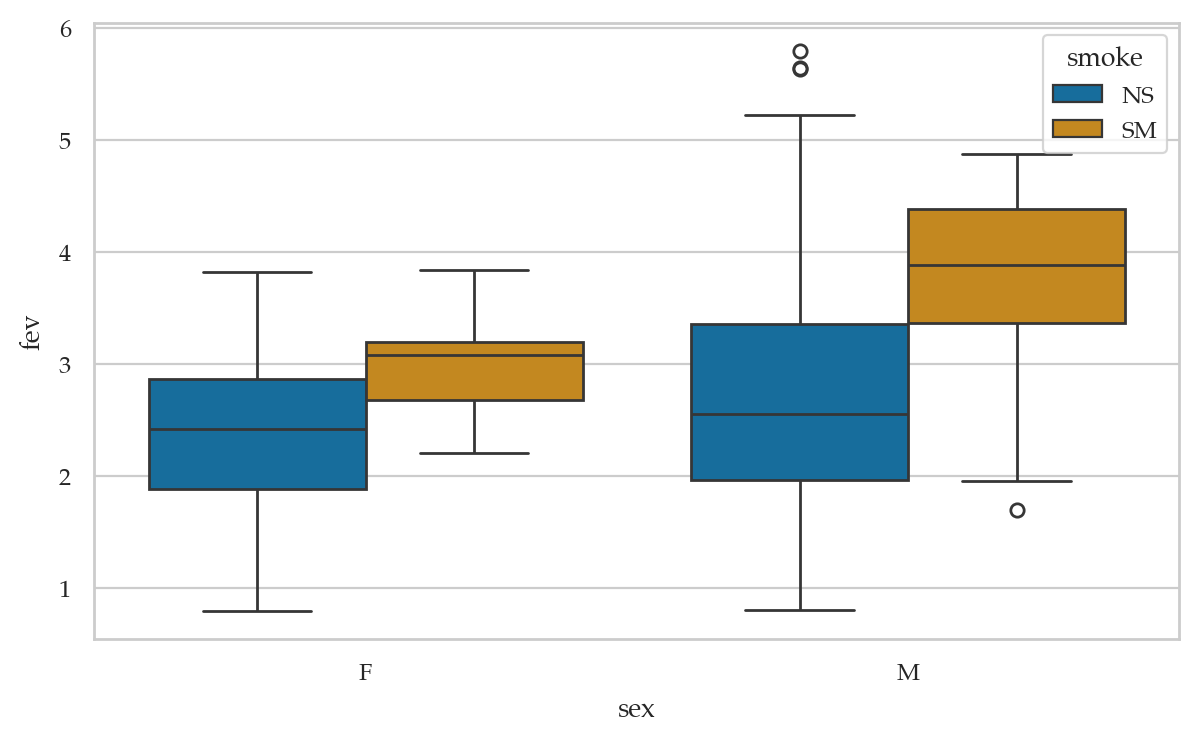

In [42]:
sns.boxplot(x="sex", y="fev", hue="smoke", data=smokefev);

Saved figure to figures/lm/modelselection/smokefev_boxplot_fev_by_sex_and_smoke.pdf
Saved figure to figures/lm/modelselection/smokefev_boxplot_fev_by_sex_and_smoke.png


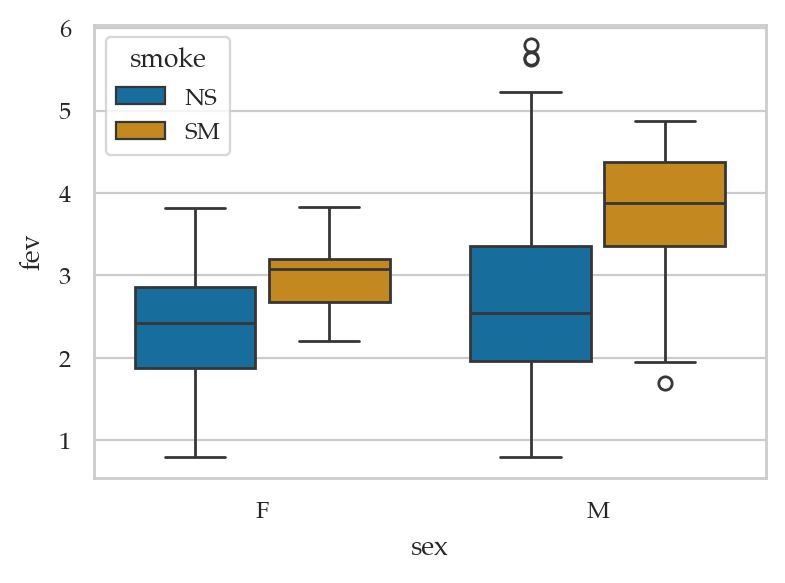

In [43]:
# FIGURES ONLY
with plt.rc_context({"figure.figsize":(4,3)}):
    sns.boxplot(x="sex", y="fev", hue="smoke", gap=0.1, data=smokefev);
    filename = os.path.join(DESTDIR, "smokefev_boxplot_fev_by_sex_and_smoke.pdf")
    savefigure(plt.gcf(), filename)

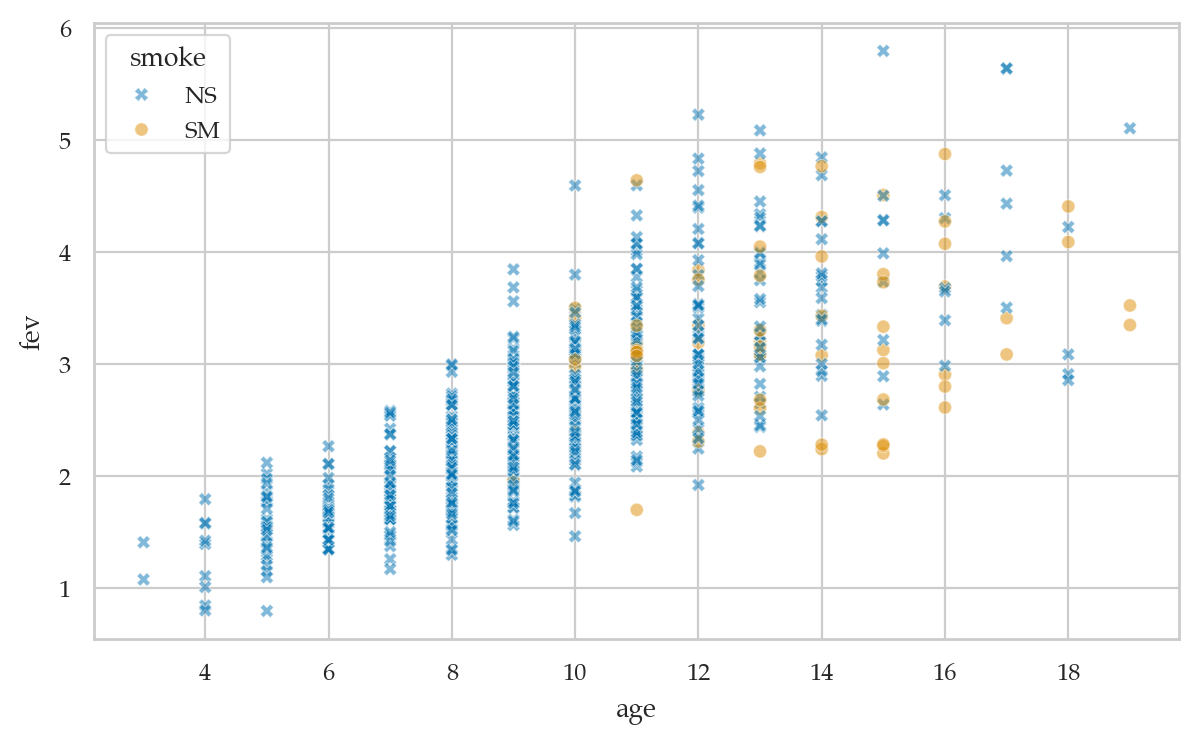

In [44]:
sns.scatterplot(data=smokefev, x="age", y="fev",
                style="smoke", hue="smoke",
                markers=["X","o"], alpha=0.5);

Saved figure to figures/lm/modelselection/smokefev_scatterplot_fev_vs_age_by_smoke.pdf
Saved figure to figures/lm/modelselection/smokefev_scatterplot_fev_vs_age_by_smoke.png


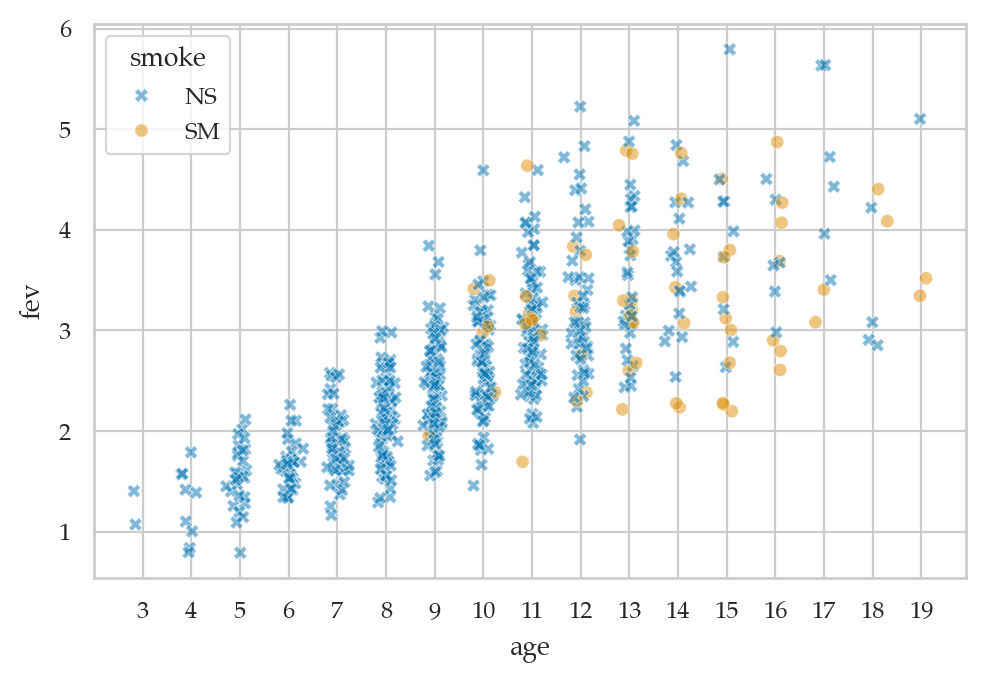

In [45]:
# FIGURES ONLY
from scipy.stats import norm

np.random.seed(41)
smokefevj = smokefev.copy()
smokefevj["age"] = smokefev["age"] + 0.1*norm(0,1).rvs(len(smokefev["age"]))


with plt.rc_context({"figure.figsize":(5,3.5)}):
    ax = sns.scatterplot(x="age", y="fev", style="smoke", hue="smoke",
                         markers=["X","o"], alpha=0.5, data=smokefevj);
    ax.set_xticks(range(3,20))
    filename = os.path.join(DESTDIR, "smokefev_scatterplot_fev_vs_age_by_smoke.pdf")
    savefigure(plt.gcf(), filename)

### Fit the unadjusted model

In [46]:
formula_unadj = "fev ~ 1 + C(smoke)"
lmfev_unadj = smf.ols(formula_unadj, data=smokefev).fit()
lmfev_unadj.params

Intercept         2.566143
C(smoke)[T.SM]    0.710719
dtype: float64

The parameter estimate $\widehat{\beta}_{\texttt{smoke}}$
we obtain from the unadjusted model echoes the simple difference in means we calculated earlier.
Any negative effect of `smoke` on `fev` is drowned by the confounding variable `age`,
which is positively associated with both `smoke` and `fev`.

### Draw a causal graphs

![Filled in causal graph for the students smoking affect FEV.](./attachments/lm/age_sex_smoke_height_fev_DAG.png)

### Fit the adjusted model

In [47]:
formula_adj = "fev ~ 1 + C(smoke) + C(sex) + age"
lmfev_adj = smf.ols(formula_adj, data=smokefev).fit()
lmfev_adj.params

Intercept         0.237771
C(smoke)[T.SM]   -0.153974
C(sex)[T.M]       0.315273
age               0.226794
dtype: float64

The interpretation of $\widehat{\beta}_{\texttt{smoke}} = -0.153974$ is that,
according to the adjusted model,
smoking decreases your FEV by $0.153974$ litres on average.

#### Practical significance

To better understand the real-world effect of smoking,
let's think about two 15 year old females:
one who smokes and the other who doesn't.

For the 15 year old nonsmoking female, the expected mean FEV is:

In [48]:
nonsmoker15F = {"age":15, "sex":"F", "smoke":"NS"}
fevNS = lmfev_adj.predict(nonsmoker15F)[0]
fevNS

3.6396839416862914

For a 15 year old, smoking female, the expected mean FEV is:

In [49]:
smoker15F = {"age":15, "sex":"F", "smoke":"SM"}
fevSM = lmfev_adj.predict(smoker15F)[0]
fevSM

3.4857098266910547

The relative reduction in FEV is:

In [50]:
(fevNS - fevSM) / fevNS

0.04230425428750262

A $4.2\%$ reduction in FEV is practically significant,
and definitely worth avoiding, especially at this early age.

## Discussion

### Metrics-based variable selection

In [51]:
# load the doctors data set
doctors = pd.read_csv("../datasets/doctors.csv")

Fit the short model 

In [52]:
formula2 = "score ~ 1 + alc + weed + exrc"
lm2 = smf.ols(formula2, data=doctors).fit()
# lm2.params

Fit long model with useful `loc` variable.

In [53]:
formula3 = "score ~ 1 + alc + weed + exrc + C(loc)"
lm3 = smf.ols(formula3, data=doctors).fit()
# lm3.params

Fit long model with useless variable `permit`.

In [54]:
formula2p = "score ~ 1 + alc + weed + exrc + permit"
lm2p = smf.ols(formula2p, data=doctors).fit()
# lm2p.params

#### Comparing metrics

In [55]:
lm2.rsquared_adj, lm3.rsquared_adj, lm2p.rsquared_adj

(0.8390497506713147, 0.8506062566189325, 0.8407115273797525)

In [56]:
lm2.aic, lm3.aic, lm2p.aic

(1103.2518084235273, 1092.5985552344712, 1102.603062693656)

The value `lm2p.aic` = 1102.60 is smaller than `lm2.aic`,
but not not that different.

In [57]:
lm2.bic, lm3.bic, lm2p.bic

(1115.4512324525256, 1107.8478352707189, 1117.8523427299037)

#### F-test for the submodel

cf. https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.compare_f_test.html

In [58]:
F, p, _ = lm3.compare_f_test(lm2)
F, p

(12.758115596295536, 0.00047598123084920574)

The $p$-value is smaller than $0.05$,
so we conclude that adding the variable `loc` improves the model.

In [59]:
F, p, _ = lm2p.compare_f_test(lm2)
F, p

(2.5857397307382257, 0.10991892492566138)

The $p$-value is greater than $0.05$,
so we conclude that adding the variable `permit` doesn't improve the model.

### Stepwise regression

### Uses and limitations of causal graphs

### Further reading on causal inference

## Exercises

In [60]:
# TODO

## Links

TODO

# CUT MATERIAL 

## Bonus examples

### Bonus example 1
Example 2 from [Why We Should Teach Causal Inference: Examples in Linear Regression With Simulated Data](https://www.tandfonline.com/doi/full/10.1080/10691898.2020.1752859)

In [61]:
np.random.seed(1897)
n = 1000
iqs = norm(100,15).rvs(n)
ltimes = 200 - iqs + norm(0,1).rvs(n) 
tscores = 0.5*iqs + 0.1*ltimes + norm(0,1).rvs(n)

bdf2 = pd.DataFrame({"iq":iqs,
                     "ltime": ltimes,
                     "tscore": tscores})

In [62]:
lm2a = smf.ols("tscore ~ 1 + ltime", data=bdf2).fit()
lm2a.params

Intercept    99.602100
ltime        -0.395873
dtype: float64

In [63]:
lm2b = smf.ols("tscore ~ 1 + ltime + iq", data=bdf2).fit()
lm2b.params

Intercept    3.580677
ltime        0.081681
iq           0.482373
dtype: float64

### Bonus example 2
Example 1 from [Why We Should Teach Causal Inference: Examples in Linear Regression With Simulated Data](https://www.tandfonline.com/doi/full/10.1080/10691898.2020.1752859)

In [64]:
np.random.seed(1896)
n = 1000
learns = norm(0,1).rvs(n)
knows = 5*learns + norm(0,1).rvs(n)
undstds = 3*knows + norm(0,1).rvs(n)

bdf1 = pd.DataFrame({"learn":learns,
                     "know": knows,
                     "undstd": undstds})

In [65]:
blm1a = smf.ols("undstd ~ 1 + learn", data=bdf1).fit()
blm1a.params

Intercept    -0.045587
learn        14.890022
dtype: float64

In [66]:
blm1b = smf.ols("undstd ~ 1 + learn + know", data=bdf1).fit()
blm1b.params

Intercept   -0.036520
learn        0.130609
know         2.975806
dtype: float64

### Bonus example 3
Example 3 from [Why We Should Teach Causal Inference: Examples in Linear Regression With Simulated Data](https://www.tandfonline.com/doi/full/10.1080/10691898.2020.1752859)

In [67]:
np.random.seed(42)
n = 1000

ntwrks = norm(0,1).rvs(n)
comps = norm(0,1).rvs(n)
boths = ((ntwrks > 1) | (comps > 1))
lucks = bernoulli(0.05).rvs(n)
proms = (1 - lucks)*boths + lucks*(1 - boths)

bdf3 = pd.DataFrame({"ntwrk": ntwrks,
                     "comp": comps,
                     "prom": proms})

Without adjusting for the collider `prom`,
there is almost no effect of the network ability on competence.

In [68]:
blm3a = smf.ols("comp ~ 1 + ntwrk", data=bdf3).fit()
blm3a.params

Intercept    0.071632
ntwrk       -0.041152
dtype: float64

But with adjustment for `prom`,
there seems to be a negative effect.

In [69]:
blm3b = smf.ols("comp ~ 1 + ntwrk + prom", data=bdf3).fit()
blm3b.params

Intercept   -0.290081
ntwrk       -0.239975
prom         1.087964
dtype: float64

The false negative effect can also appear from sampling bias,
e.g. if we restrict our analysis only to people who were promoted.

In [70]:
df3proms = bdf3[bdf3["prom"]==1]
blm3c = smf.ols("comp ~ ntwrk", data=df3proms).fit()
blm3c.params

Intercept    0.898530
ntwrk       -0.426244
dtype: float64

### Bonus example 4: benefits of random assignment
Example 4 from [Why We Should Teach Causal Inference: Examples in Linear Regression With Simulated Data](https://www.tandfonline.com/doi/full/10.1080/10691898.2020.1752859)

In [71]:
np.random.seed(1896)
n = 1000

iqs = norm(100,15).rvs(n)
groups = bernoulli(p=0.5).rvs(n)
ltimes = 80*groups + 120*(1-groups)
tscores = 0.5*iqs + 0.1*ltimes + norm(0,1).rvs(n)

bdf4 = pd.DataFrame({"iq":iqs,
                     "ltime": ltimes,
                     "tscore": tscores})

In [72]:
# non-randomized            # random assignment
bdf2.corr()["iq"]["ltime"],  bdf4.corr()["iq"]["ltime"]

(-0.9979264589333364, -0.020129851374243904)

In [73]:
bdf4.groupby("ltime")["iq"].mean()

ltime
80     99.980423
120    99.358152
Name: iq, dtype: float64

In [74]:
blm4a = smf.ols("tscore ~ 1 + ltime", data=bdf4).fit()
blm4a.params

Intercept    50.688293
ltime         0.091233
dtype: float64

In [75]:
blm4b = smf.ols("tscore ~ 1 + ltime + iq", data=bdf4).fit()
blm4b.params

Intercept   -0.303676
ltime        0.099069
iq           0.503749
dtype: float64

In [76]:
blm4c = smf.ols("tscore ~ 1 + iq", data=bdf4).fit()
blm4c.params

Intercept    9.896117
iq           0.501168
dtype: float64

#### Side-quest (causal influence of `mem`)

Suppose we're interested in ...
mem wasn't randomized, but because we de

In [77]:
blm8c = smf.ols("score ~ 1 + mem", data=df2r).fit()
blm8c.params

Intercept    17.382804
mem          10.430159
dtype: float64